In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms, models

from sklearn.metrics import classification_report, confusion_matrix
import torchvision
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0532.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0282.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1401.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0914.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0691.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0972.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0818.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0463.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0930.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1323.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1347.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_1354.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0704.jpg
/kaggle/input/brain-tumor-mri-dataset/Training/pituitary/Tr-pi_0

In [2]:
!nvidia-smi

Fri Sep 26 13:49:24 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla P100-PCIE-16GB           Off |   00000000:00:04.0 Off |                    0 |
| N/A   35C    P0             25W /  250W |       0MiB /  16384MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

Bazı gerekli ayarlamalar ve augmentasyonlar uyguladım.

In [3]:
from torchvision import transforms

# Eğer transfer learning yapacaksan ImageNet normalizasyonu iyi bir başlangıçtır:
imagenet_mean = [0.485, 0.456, 0.406]
imagenet_std  = [0.229, 0.224, 0.225]

# TRAIN transforms (augmentasyonlar burada)
train_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),  #Aşağıdaki kodda gri görsel var mı diye kontrol ettim, ve olduğu için RGB gibi bütün görselleri 3 kanala çevirdim.
    transforms.Resize((256,256)),                  # önce biraz büyüt
    transforms.RandomResizedCrop(224),             # sonra 224x224'e kırp (augmentasyon)
    transforms.RandomHorizontalFlip(p=0.5),       # yarı yarıya yatay flip
    transforms.RandomRotation(10),                 # hafif dönme
    transforms.ColorJitter(brightness=0.1, contrast=0.1), # hafif renk oynaması
    transforms.ToTensor(),                         # PIL -> Tensor (C,H,W), [0,1]
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std) # normalize
])

# VALIDATION / TEST transforms (augmentasyon yok, sadece sabit hazırlık)
val_transform = transforms.Compose([
    transforms.Grayscale(num_output_channels=3),#Aşağıdaki kodda gri görsel var mı diye kontrol ettim, ve olduğu için RGB gibi bütün görselleri 3 kanala çevirdim.
    transforms.Resize((256,256)),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=imagenet_mean, std=imagenet_std)
])


Burada gri görüntüler var mı var ise kaçta tane var onu kontrol etmek istedim.

In [4]:
import os
from PIL import Image

# Dataset klasörleri (train + test)
train_dir = "/kaggle/input/brain-tumor-mri-dataset/Training"
test_dir  = "/kaggle/input/brain-tumor-mri-dataset/Testing"

# Sayaçlar
count_gray = 0
count_rgb = 0

# Bütün klasörleri gez
for base_dir in [train_dir, test_dir]:
    for root, dirs, files in os.walk(base_dir):
        for file in files:
            if file.endswith((".jpg", ".png", ".jpeg")):
                path = os.path.join(root, file)
                try:
                    img = Image.open(path)
                    if img.mode == "L":   # grayscale
                        count_gray += 1
                    elif img.mode == "RGB": # renkli
                        count_rgb += 1
                except:
                    pass  # bozuk dosya olursa atla

print("Toplam gri (L):", count_gray)
print("Toplam RGB:", count_rgb)
print("Toplam:", count_gray + count_rgb)


Toplam gri (L): 3093
Toplam RGB: 3926
Toplam: 7019


In [5]:
data_root = "/kaggle/input/brain-tumor-mri-dataset/Training"  # veya Testing
dataset = datasets.ImageFolder(root=data_root, transform=train_transform)  # train_transform veya val_transform
print("Sınıf isimleri:", dataset.classes)   # örn ['glioma_tumor','meningioma_tumor',...]


Sınıf isimleri: ['glioma', 'meningioma', 'notumor', 'pituitary']


Kendime train ,test ve validation için dataseti ayarladım.

In [6]:
from sklearn.model_selection import train_test_split
from torch.utils.data import Subset

# 1) tüm veri (transform yok) olarak oku sadece sample listesi almak için
full_dataset = datasets.ImageFolder(root="/kaggle/input/brain-tumor-mri-dataset/Training", transform=None)
targets = full_dataset.targets  # her resim için sınıf indeksi (0..3)
indices = list(range(len(full_dataset)))

# 2) önce test'i ayır (örneğin %15)
trainval_idx, test_idx = train_test_split(indices, test_size=0.15, stratify=targets, random_state=42)

# 3) sonra train / val olarak ayır (hedef: toplamda %70 train, %15 val, %15 test)
#    trainval içinden val = 15/85 ~ 0.17647 oranında seç
train_idx, val_idx = train_test_split(trainval_idx, test_size=15/85, 
                                      stratify=[targets[i] for i in trainval_idx],
                                      random_state=42)

# 4) Artık her set için ImageFolder + uygun transform ile Subset oluştur
train_dataset = datasets.ImageFolder(root="/kaggle/input/brain-tumor-mri-dataset/Training", transform=train_transform)
val_dataset   = datasets.ImageFolder(root="/kaggle/input/brain-tumor-mri-dataset/Training", transform=val_transform)
test_dataset  = datasets.ImageFolder(root="/kaggle/input/brain-tumor-mri-dataset/Training", transform=val_transform)

train_dataset = Subset(train_dataset, train_idx)
val_dataset   = Subset(val_dataset, val_idx)
test_dataset  = Subset(test_dataset, test_idx)


In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class CustomCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):
        super(CustomCNN, self).__init__()

        self.conv1 = nn.Conv2d(3, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout = nn.Dropout(dropout_rate)

        # Dinamik flatten size
        self.flatten_dim = self._get_flatten_size()
        self.fc1 = nn.Linear(self.flatten_dim, 256)
        self.fc2 = nn.Linear(256, num_classes)

    def _get_flatten_size(self):
        with torch.no_grad():
            x = torch.zeros(1, 3, 224, 224)
            x = self.pool(F.relu(self.conv1(x)))
            x = self.pool(F.relu(self.conv2(x)))
            x = self.pool(F.relu(self.conv3(x)))
            return x.view(1, -1).size(1)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        x = x.view(x.size(0), -1)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x


num_classes = len(dataset.classes)
model = CustomCNN(num_classes, dropout_rate=0.5)


In [8]:
def train_model(model, train_loader, val_loader, criterion, optimizer, device, num_epochs):
    best_val_acc = 0
    best_model_wts = None
    
    # epoch değerlerini kaydetmek için listeler
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []

    for epoch in range(num_epochs):
        # ---- Training ----
        model.train()
        running_loss, correct, total = 0.0, 0, 0

        for images, labels in train_loader:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        train_loss = running_loss / total
        train_acc = 100 * correct / total

        # ---- Validation ----
        model.eval()
        val_loss, correct, total = 0.0, 0, 0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)

                val_loss += loss.item() * labels.size(0)
                _, predicted = outputs.max(1)
                total += labels.size(0)
                correct += predicted.eq(labels).sum().item()

        val_loss /= total
        val_acc = 100 * correct / total

        # listelere kaydet
        train_losses.append(train_loss)
        val_losses.append(val_loss)
        train_accs.append(train_acc)
        val_accs.append(val_acc)

        # Best model kaydet
        if val_acc > best_val_acc:
            best_val_acc = val_acc
            best_model_wts = model.state_dict()

        print(f"Epoch [{epoch+1}/{num_epochs}] "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.2f}% | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.2f}%")

    if best_model_wts:
        model.load_state_dict(best_model_wts)

    return model, train_losses, val_losses, train_accs, val_accs


def evaluate(model, test_loader, device, class_names):
    model.eval()
    all_preds, all_labels = [], []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, preds = outputs.max(1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    print("\n=== Test Sonuçları ===")
    print(classification_report(all_labels, all_preds, target_names=class_names))
    print("Confusion Matrix:\n", confusion_matrix(all_labels, all_preds))

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


Burada en iyi batch size hangisi onu görmek istediğiniz için fonksiyon yazdım ve ona göre belirledim.

In [10]:
def get_loaders(batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True,  num_workers=4, pin_memory=True)
    val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=2, pin_memory=True)
    return train_loader, val_loader, test_loader


En iyi batch size ve epoch ayarlama

In [11]:
batch_sizes = [16, 32, 64]   # Denemek istediğin batch_size değerleri
epoch_list = [15, 25]        # Denemek istediğin epoch sayıları
results = []


for bs in batch_sizes:
    for num_epochs in epoch_list:
        print(f"\n--- batch_size={bs}, epochs={num_epochs} ---")

        train_loader, val_loader, test_loader = get_loaders(bs)
        model = CustomCNN(num_classes, dropout_rate=0.5).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
        criterion = nn.CrossEntropyLoss()

        model, train_losses, val_losses, train_accs, val_accs = train_model(
    model, train_loader, val_loader, criterion, optimizer, device, num_epochs
)

        evaluate(model, test_loader, device, full_dataset.classes)



--- batch_size=16, epochs=15 ---
Epoch [1/15] Train Loss: 1.0879, Acc: 52.30% | Val Loss: 0.7743, Acc: 74.10%
Epoch [2/15] Train Loss: 0.9791, Acc: 59.13% | Val Loss: 0.7572, Acc: 71.65%
Epoch [3/15] Train Loss: 0.9121, Acc: 63.01% | Val Loss: 0.6427, Acc: 78.41%
Epoch [4/15] Train Loss: 0.8587, Acc: 65.28% | Val Loss: 0.5547, Acc: 78.65%
Epoch [5/15] Train Loss: 0.8331, Acc: 66.46% | Val Loss: 0.5498, Acc: 81.91%
Epoch [6/15] Train Loss: 0.8281, Acc: 65.86% | Val Loss: 0.5837, Acc: 78.53%
Epoch [7/15] Train Loss: 0.7860, Acc: 68.46% | Val Loss: 0.5621, Acc: 78.18%
Epoch [8/15] Train Loss: 0.7701, Acc: 68.98% | Val Loss: 0.4874, Acc: 82.26%
Epoch [9/15] Train Loss: 0.7596, Acc: 69.83% | Val Loss: 0.4442, Acc: 85.76%
Epoch [10/15] Train Loss: 0.7311, Acc: 69.71% | Val Loss: 0.4234, Acc: 85.76%
Epoch [11/15] Train Loss: 0.7317, Acc: 70.99% | Val Loss: 0.4115, Acc: 86.46%
Epoch [12/15] Train Loss: 0.7161, Acc: 71.39% | Val Loss: 0.3901, Acc: 87.05%
Epoch [13/15] Train Loss: 0.6996, Acc: 

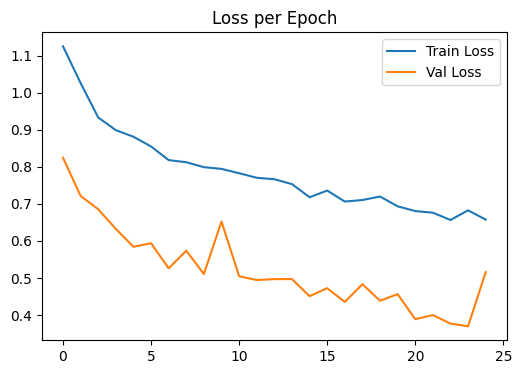

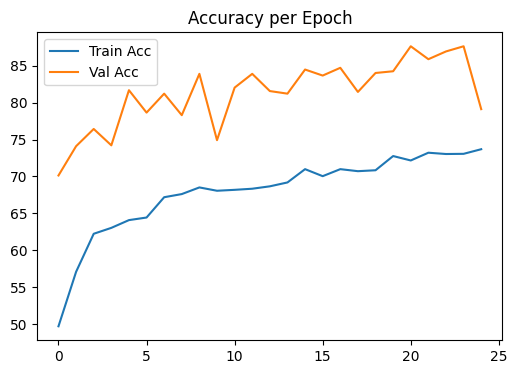

In [12]:
import matplotlib.pyplot as plt

# Loss grafiği
plt.figure(figsize=(6,4))
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title("Loss per Epoch")
plt.show()

# Accuracy grafiği
plt.figure(figsize=(6,4))
plt.plot(train_accs, label='Train Acc')
plt.plot(val_accs, label='Val Acc')
plt.legend()
plt.title("Accuracy per Epoch")
plt.show()


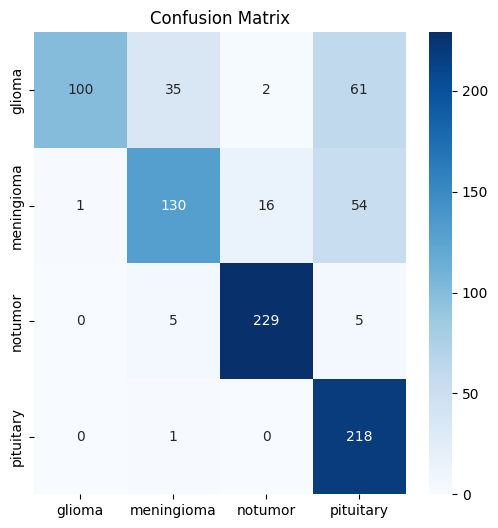

              precision    recall  f1-score   support

      glioma       0.99      0.51      0.67       198
  meningioma       0.76      0.65      0.70       201
     notumor       0.93      0.96      0.94       239
   pituitary       0.64      1.00      0.78       219

    accuracy                           0.79       857
   macro avg       0.83      0.78      0.77       857
weighted avg       0.83      0.79      0.78       857



In [13]:
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import numpy as np

y_true, y_pred = [], []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = outputs.max(1)
        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predicted.cpu().numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=dataset.classes, yticklabels=dataset.classes)
plt.title("Confusion Matrix")
plt.show()

# Classification Report
print(classification_report(y_true, y_pred, target_names=dataset.classes))


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 39.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 92.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 51.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 13.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 8.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 32.7 MB/s 

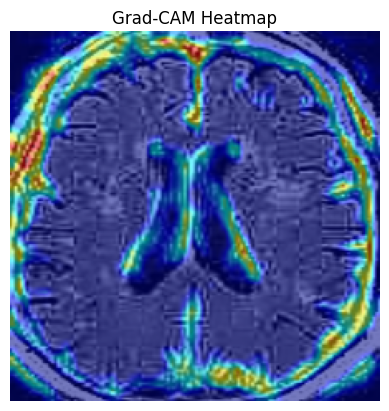

In [14]:
!pip install grad-cam
from pytorch_grad_cam import GradCAM
from pytorch_grad_cam.utils.image import show_cam_on_image

# Hedef katman olarak son convolution katmanını seç
target_layer = model.conv3  

# Grad-CAM nesnesini oluştur
cam = GradCAM(model=model, target_layers=[target_layer])  # use_cuda yok artık

# Test setinden bir batch al
images, labels = next(iter(test_loader))
images = images.to(device)

# Grad-CAM hesapla
grayscale_cam = cam(input_tensor=images)
grayscale_cam = grayscale_cam[0, :]  # İlk görsel

# Orijinal görseli normalleştir
rgb_img = images[0].permute(1,2,0).detach().cpu().numpy()
rgb_img = (rgb_img - rgb_img.min()) / (rgb_img.max() - rgb_img.min())

# Heatmap oluştur
heatmap = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
plt.imshow(heatmap)
plt.title("Grad-CAM Heatmap")
plt.axis('off')
plt.show()
